In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from PIL import Image
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib inline

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
RANDOM_SEED = 42
BATCH_SIZE = 256
EPOCHS = 20
LR = 3e-2
GAMMA = 0.7

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
train_dir = './data_tmp/train'
test_dir = './data_tmp/test'

train_list = glob.glob(os.path.join(train_dir,'*.png'))
test_list = glob.glob(os.path.join(test_dir, '*.png'))

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

labels = [path.split('/')[-1].split('_')[0] for path in train_list]

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          shuffle=True,
                                          random_state=RANDOM_SEED)

print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

Train Data: 900
Test Data: 300
Train Data: 720
Validation Data: 180
Test Data: 300


In [7]:
class GWDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        # Apply transformations if provided
        img_transformed = self.transform(img)
        img_transformed = img_transformed[:3, :, :]  # Ensure correct format for channels

        # Determine the label based on filename
        label_str = img_path.split("/")[-1].split("_")[0]
        if label_str == "eccentric":
            label = 1
        elif label_str == "unlensed":
            label = 2
        else:
            label = 0 

        return img_transformed, label

train_data = GWDataset(train_list, transform=train_transforms)
valid_data = GWDataset(valid_list, transform=test_transforms)
test_data = GWDataset(test_list, transform=test_transforms)

train_loader = DataLoader(dataset = train_data, num_workers=os.cpu_count(), batch_size=BATCH_SIZE, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, num_workers=os.cpu_count(), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset = test_data, num_workers=os.cpu_count(), batch_size=BATCH_SIZE, shuffle=True)

In [8]:
print(f"Train Dataset Length: {len(train_data)}, Train Dataloader Length: {len(train_loader)}")

print(f"Validation Dataset Length: {len(valid_data)}, Validation Dataloader Length: {len(valid_loader)}")

Train Dataset Length: 720, Train Dataloader Length: 3
Validation Dataset Length: 180, Validation Dataloader Length: 1


In [9]:
tmp = next(iter(train_loader))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

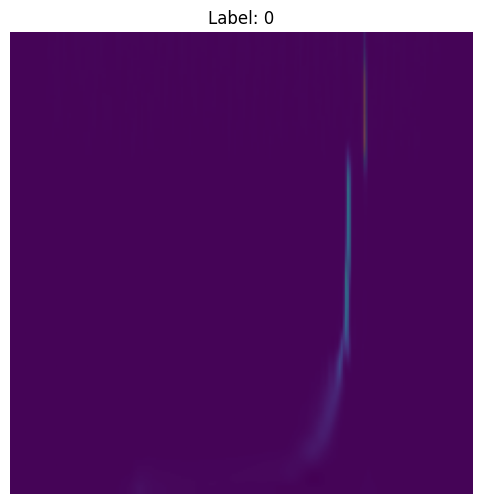

In [10]:
plt.figure(figsize=(12, 6), facecolor=None)
plt.imshow(tmp[0][10].numpy().transpose(1, 2, 0))
plt.title(f"Label: {tmp[1][10]}")
plt.axis(False)

In [11]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
model0 = CNN_Model().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=GAMMA)

In [13]:
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, scheduler, epochs=EPOCHS):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        # Validation
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            valid_correct = 0
            valid_total = 0
            
            for val_images, val_labels in valid_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                v_loss = loss_fn(val_outputs, val_labels)
                
                valid_loss += v_loss.item() * val_images.size(0)
                _, v_predicted = torch.max(val_outputs.data, 1)
                valid_total += val_labels.size(0)
                valid_correct += (v_predicted == val_labels).sum().item()
            
            epoch_valid_loss = valid_loss / len(valid_loader.dataset)
            epoch_valid_acc = valid_correct / valid_total
            val_losses.append(epoch_valid_loss)

            print(f"Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {epoch_valid_acc:.4f}")
        
        scheduler.step()
    
    return train_losses, val_losses


In [14]:
train_loss, val_loss = train_model(model0, train_loader, valid_loader, loss_fn, optimizer, scheduler, epochs=EPOCHS)

Epoch [1/20], Loss: 2221.4086, Accuracy: 0.3472
Validation Loss: 9.9348, Validation Accuracy: 0.3333
Epoch [2/20], Loss: 283.9526, Accuracy: 0.3111
Validation Loss: 4.1373, Validation Accuracy: 0.3333
Epoch [3/20], Loss: 2.4309, Accuracy: 0.3333
Validation Loss: 1.0997, Validation Accuracy: 0.3333
Epoch [4/20], Loss: 1.0988, Accuracy: 0.3389
Validation Loss: 1.0996, Validation Accuracy: 0.3333
Epoch [5/20], Loss: 1.1002, Accuracy: 0.3333
Validation Loss: 1.0934, Validation Accuracy: 0.3389
Epoch [6/20], Loss: 1.1007, Accuracy: 0.3333
Validation Loss: 1.1005, Validation Accuracy: 0.3333
Epoch [7/20], Loss: 1.1005, Accuracy: 0.3333
Validation Loss: 1.1002, Validation Accuracy: 0.3333
Epoch [8/20], Loss: 1.0998, Accuracy: 0.3333
Validation Loss: 1.0992, Validation Accuracy: 0.3333
Epoch [9/20], Loss: 1.0993, Accuracy: 0.3278
Validation Loss: 1.0985, Validation Accuracy: 0.3333
Epoch [10/20], Loss: 1.0987, Accuracy: 0.3139
Validation Loss: 1.0982, Validation Accuracy: 0.3333
Epoch [11/20],

KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, test_loader, loss_fn, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            val_outputs = model(test_images)
            v_loss = loss_fn(val_outputs, test_labels)

            valid_loss += v_loss.item() * test_images.size(0)
            _, v_predicted = torch.max(val_outputs, 1)

            valid_total += test_labels.size(0)
            valid_correct += (v_predicted == test_labels).sum().item()

            all_preds.extend(v_predicted.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

    epoch_valid_loss = valid_loss / len(test_loader.dataset)
    epoch_valid_acc = valid_correct / valid_total

    print(f"Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {epoch_valid_acc:.4f}")

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return all_preds, all_labels

Validation Loss: 4.6178, Validation Accuracy: 0.3433


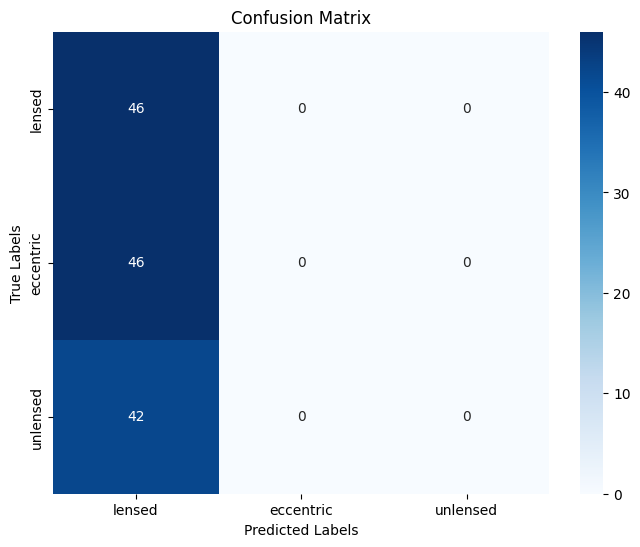

([np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64

In [ ]:
evaluate_model(model0, test_loader, loss_fn, device, class_names=['lensed', 'eccentric', 'unlensed'])

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [13]:
# Save the model
model_path = 'cnn_model0.pth'
torch.save(model0.state_dict(), model_path)
# # Load the model
# model1 = CNN_Model().to(device)
# model1.load_state_dict(torch.load(model_path))

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [15]:
model0 = CNN_Model().to(device)
model_path = 'cnn_mode0.pth'
model0.load_state_dict(torch.load(model_path))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=GAMMA)

In [16]:
model0

CNN_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

Validation Loss: 0.3377, Validation Accuracy: 0.9222


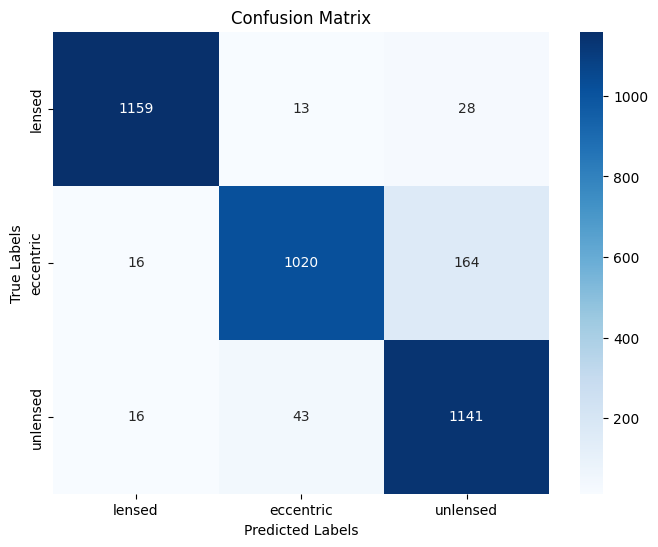

In [19]:
all_preds, all_labels = evaluate_model(model0, test_loader, loss_fn, device, class_names=['lensed', 'eccentric', 'unlensed'])

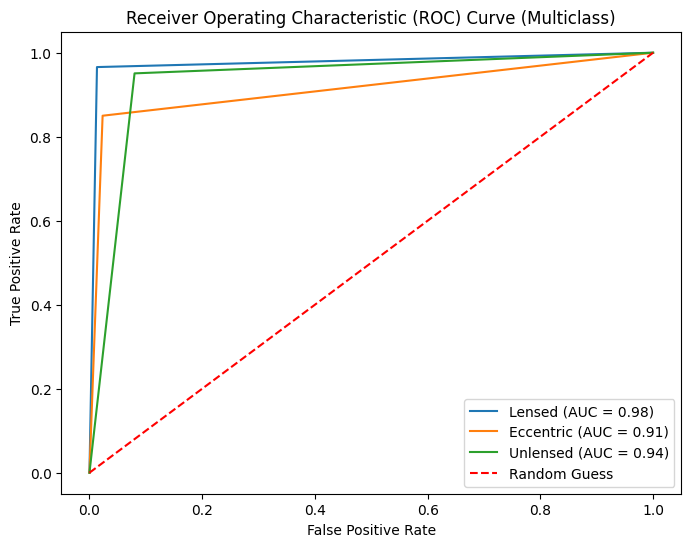

In [25]:
# Assuming class_mapping and cm_labels are defined
class_mapping = {0: 'Lensed', 1: 'Eccentric', 2: 'Unlensed'}
cm_labels = ['Lensed', 'Eccentric', 'Unlensed']

# If labels are class names (strings), use reverse mapping
reverse_mapping = {v: k for k, v in class_mapping.items()}

# Automatically handle both string and numeric input
def to_numeric(labels):
    if isinstance(labels[0], str):
        return np.array([reverse_mapping[label] for label in labels])
    return np.array(labels)

all_labels_numeric = to_numeric(all_labels)
all_preds_numeric = to_numeric(all_preds)

# Binarize for one-vs-rest ROC computation
binarizer = LabelBinarizer()
all_labels_binarized = binarizer.fit_transform(all_labels_numeric)
all_preds_binarized = binarizer.transform(all_preds_numeric)

# If only two classes, LabelBinarizer returns 1 column; fix that:
if all_labels_binarized.shape[1] == 1:
    all_labels_binarized = np.hstack((1 - all_labels_binarized, all_labels_binarized))
    all_preds_binarized = np.hstack((1 - all_preds_binarized, all_preds_binarized))

# Plot ROC
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(cm_labels):
    fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_preds_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()